In [1]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import pandas as pd
from scipy.stats import entropy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:


# Define categories
categories = ["Background", "Public Building", "Agent"]

# Define the fixation sequence with more diverse transitions
fixation_sequence = [
    "Background", "Public Building", "Agent", "Public Building", "Agent", 
    "Background", "Public Building", "Agent", "Public Building", "Background"
]

# Create a transition count matrix
category_indices = {category: i for i, category in enumerate(categories)}
transition_counts = np.zeros((len(categories), len(categories)))

# Count transitions between categories
for i in range(len(fixation_sequence) - 1):
    from_category = fixation_sequence[i]
    to_category = fixation_sequence[i + 1]
    transition_counts[category_indices[from_category], category_indices[to_category]] += 1

# Normalize rows to get transition probabilities
transition_probabilities = transition_counts / transition_counts.sum(axis=1, keepdims=True)

# Function to compute Chao-Shen entropy correction
def chao_shen_entropy(probabilities):
    """Compute Chao-Shen entropy correction for small sample sizes."""
    probabilities = probabilities[probabilities > 0]  # Remove zero probabilities
    n = len(probabilities)
    return entropy(probabilities, base=2) * (1 - (n - 1) / (2 * sum(probabilities)))

# Recalculate singleton transitions correctly
singleton_counts = np.sum(transition_counts == 1, axis=1)
total_transitions = np.sum(transition_counts, axis=1)

# Avoid division by zero
coverage_estimator = np.where(total_transitions > 0, 1 - (singleton_counts / total_transitions), 1)

# Apply the Chao-Shen correction to compute entropy for each category
adjusted_probabilities = transition_probabilities * coverage_estimator[:, np.newaxis]
category_entropies = {category: chao_shen_entropy(adjusted_probabilities[i]) for i, category in enumerate(categories)}

# Compute the stationary distribution from the corrected transition matrix
eigenvalues, eigenvectors = np.linalg.eig(transition_probabilities.T)
stationary_distribution = np.abs(eigenvectors[:, np.argmax(np.real(eigenvalues))])
stationary_distribution /= stationary_distribution.sum()  # Normalize

# Compute global entropy as the weighted sum of category-specific entropy values
global_entropy = np.sum(stationary_distribution * np.array(list(category_entropies.values())))

# Compute theoretical maximum entropy
num_categories = len(categories)
max_entropy = np.log2(num_categories)

# Normalize global entropy
normalized_global_entropy = global_entropy / max_entropy

# Convert results to a DataFrame for better readability
corrected_gte_entropy_df = pd.DataFrame.from_dict(category_entropies, orient='index', columns=['Chao-Shen GTE'])
corrected_gte_entropy_df.loc["Global Entropy"] = global_entropy
corrected_gte_entropy_df.loc["Normalized Global Entropy"] = normalized_global_entropy


<Axes: >

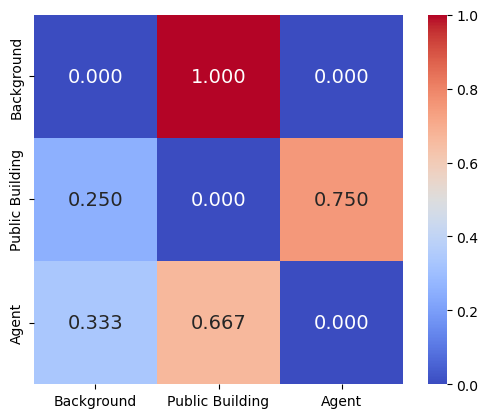

In [3]:
sns.heatmap(transition_probabilities, annot=True, fmt=".3f", annot_kws={"size": 14},
                cmap="coolwarm", cbar=True, square=True,  xticklabels=categories, yticklabels=categories)

<Axes: >

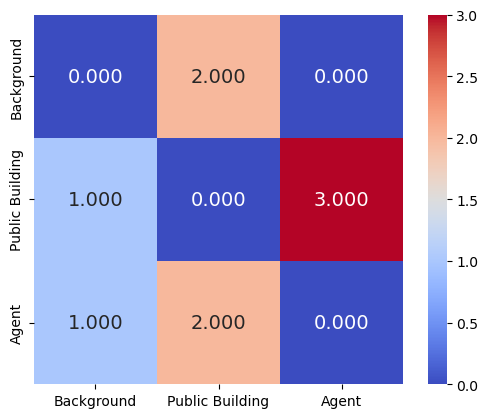

In [4]:
sns.heatmap(transition_counts, annot=True, fmt=".3f", annot_kws={"size": 14},
                cmap="coolwarm", cbar=True, square=True,  xticklabels=categories, yticklabels=categories)

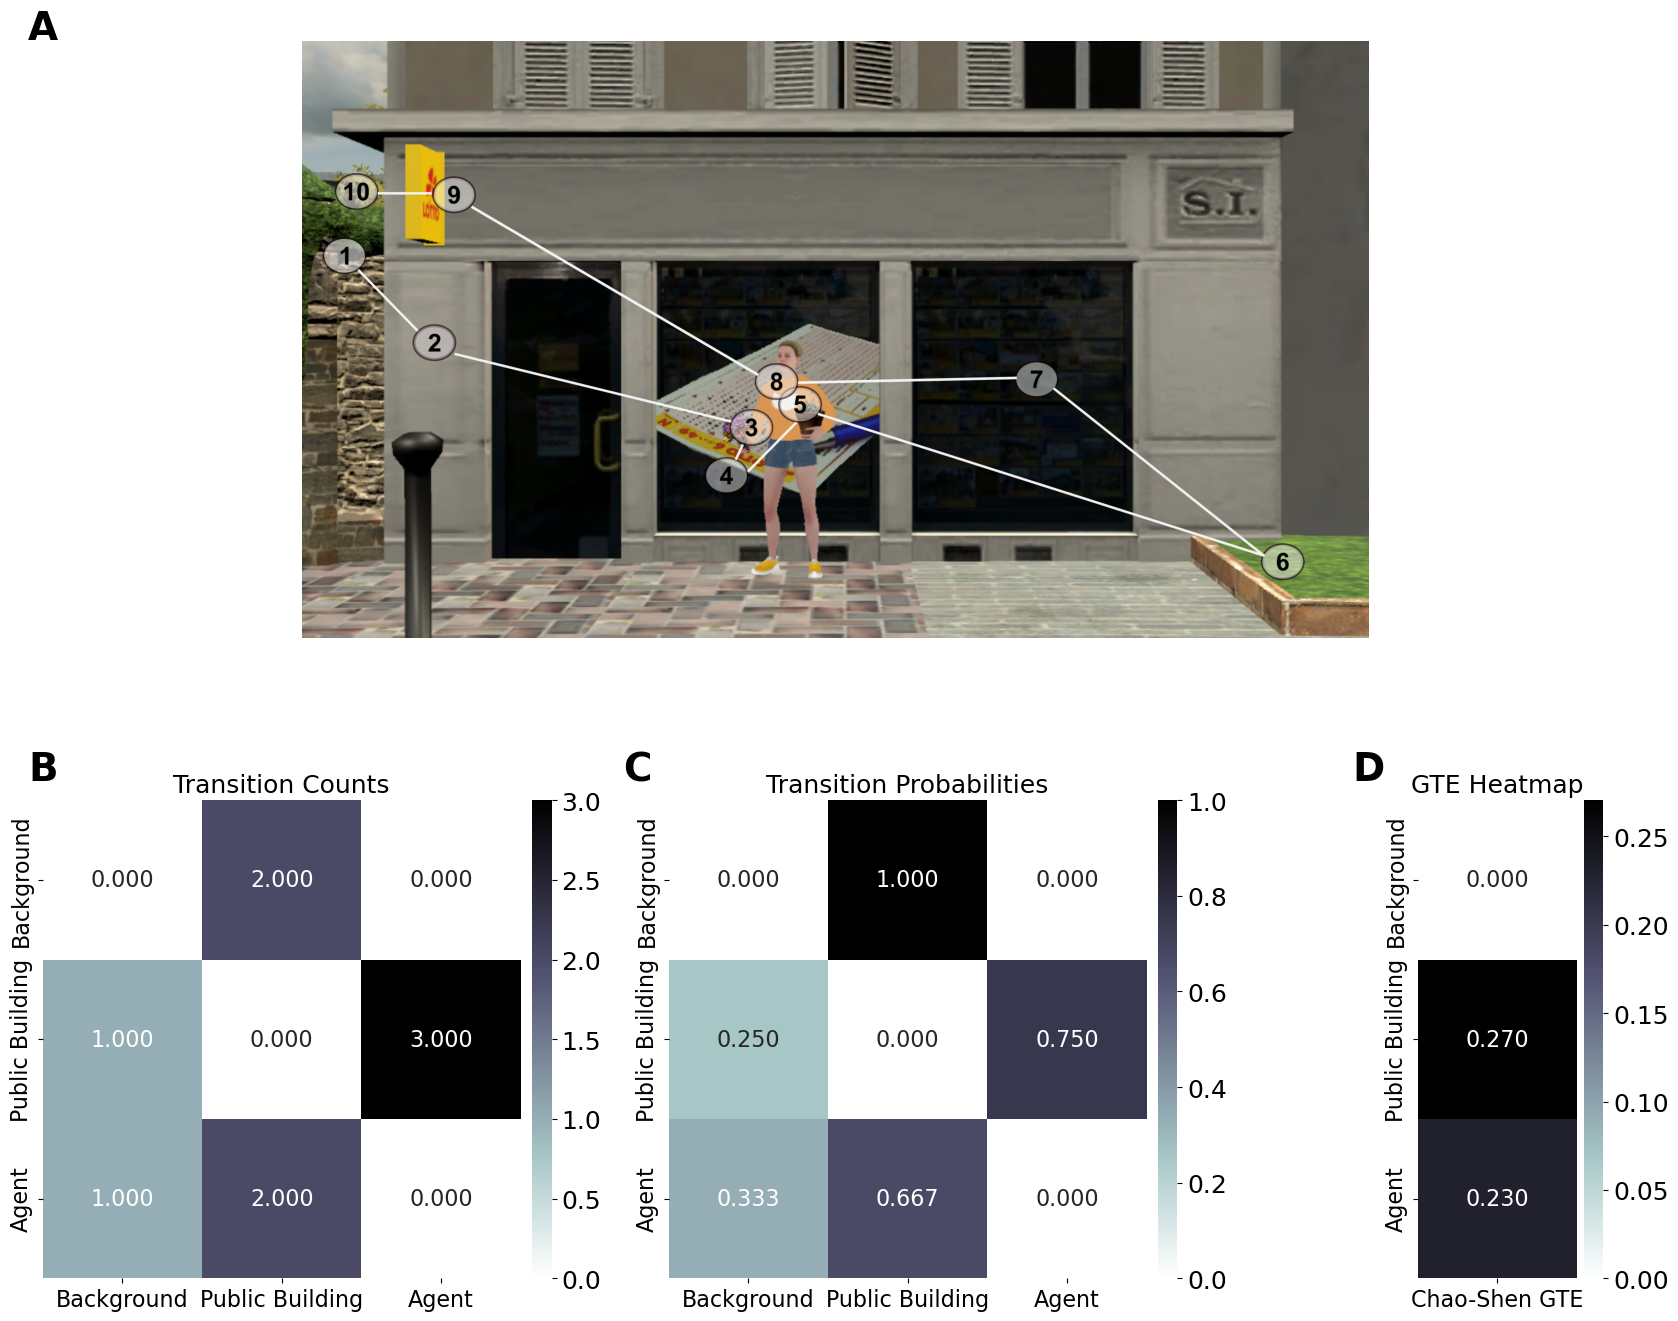

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

# Load the actual image (replace with your correct file path)
image_path = "/Users/tracysanchezpacheco/Library/CloudStorage/OneDrive-Personal/PhD/Creation/Entropy_Gaze_transition.jpg"
image = mpimg.imread(image_path)  # Ensure this path is correct

# Create a figure with a custom grid layout
fig = plt.figure(figsize=(17, 13))

# Create a wide image panel spanning all three columns
ax_img = fig.add_subplot(2, 1, 1)  
ax_img.imshow(image)
ax_img.axis("off")  # Hide axes
#ax_img.set_title("Gaze Transition Visualization", fontsize=16)

# Create a grid layout for the second row with adjusted widths
gs = fig.add_gridspec(2, 3, height_ratios=[1.5, 1], width_ratios=[1, 1, 0.6])  

# Heatmap of raw transition counts
ax1 = fig.add_subplot(gs[1, 0])  
cbar1 = sns.heatmap(transition_counts, annot=True, fmt=".3f", annot_kws={"size": 16},
            cmap="bone_r", cbar=True, square=True, 
            xticklabels=categories, yticklabels=categories, ax=ax1,
            cbar_kws={"shrink": 1, "aspect": 25, "pad": 0.02})  # Increase color bar size
ax1.set_title("Transition Counts", fontsize=18)
cbar1.collections[0].colorbar.ax.tick_params(labelsize=18)  # Increase color bar tick size

# Heatmap of transition probabilities
ax2 = fig.add_subplot(gs[1, 1])  
cbar2 = sns.heatmap(transition_probabilities, annot=True, fmt=".3f", annot_kws={"size": 16},
            cmap="bone_r", cbar=True, square=True,
            xticklabels=categories, yticklabels=categories, ax=ax2,
            cbar_kws={"shrink": 1, "aspect": 25, "pad": 0.02})  # Increase color bar size
ax2.set_title("Transition Probabilities", fontsize=18)
cbar2.collections[0].colorbar.ax.tick_params(labelsize=18)  # Increase color bar tick size

# Heatmap of Chao-Shen GTE entropy values (smaller panel)
ax3 = fig.add_subplot(gs[1, 2])  

cbar3 = sns.heatmap(corrected_gte_entropy_df[:-2], annot=True, fmt=".3f", annot_kws={"size": 16},
            cmap="bone_r", cbar=True, square=True, ax=ax3,
            cbar_kws={"shrink": 1, "aspect": 25, "pad": 0.02})  # Increase color bar size
ax3.set_title("GTE Heatmap", fontsize=18)
cbar3.collections[0].colorbar.ax.tick_params(labelsize=18)  # Increase color bar tick size


# Increase tick label size for all heatmaps
for ax in [ax1, ax2, ax3]:
    ax.tick_params(axis='both', which='both', labelsize=16)
    


# Add subplot labels (A, B, C, D)
fig.text(0.03, 0.99, "A", fontsize=28, fontweight="bold", ha="center")  # Top image
fig.text(0.03, 0.42, "B", fontsize=28, fontweight="bold", ha="center")  # First heatmap
fig.text(0.38, 0.42, "C", fontsize=28, fontweight="bold", ha="center")  # Second heatmap
fig.text(0.81, 0.42, "D", fontsize=28, fontweight="bold", ha="center")  # Third heatmap

# Adjust layout for better spacing
plt.tight_layout()
# Save the figure
plt.savefig("/Volumes/TwoTeras/2_DataSets_Experiments_1_2/Plots/Methods_Entropy_Transitions.png", dpi=900, bbox_inches='tight')
plt.show()

In [6]:
corrected_gte_entropy_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, Background to Normalized Global Entropy
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Chao-Shen GTE  5 non-null      float64
dtypes: float64(1)
memory usage: 80.0+ bytes
